# **Multi-Store Multi-Item Demand Forecasting for Smarter Inventory Planning in E-Commerce**

In this project, I worked on the challenge of forecasting product demand across multiple stores and items using historical sales data from the Store Item Demand Forecasting dataset. For an e-commerce business, demand forecasting is not just a technical exercise, it directly affects inventory planning, supply chain efficiency, and customer satisfaction.

The objective is to build models that can predict future sales at the store-item level, so that the business can reduce stockouts, avoid overstocking, and plan promotions more effectively. Traditional approaches often rely on simple moving averages or seasonal heuristics, but these tend to break down when the business scales or when there are strong seasonal effects and promotions. By framing this as a supervised learning problem with time series data, I trained models that learn from both temporal patterns and additional features like seasonality, store effects, or item-specific behavior.

Model performance was measured using RMSE, which aligns with the goal of improving forecast accuracy and reducing costly inventory mistakes. The minimum acceptable performance would be one that consistently improves upon naive baselines, such as last week’s or last year’s sales, because even modest improvements translate into significant financial impact at scale. This type of problem is comparable to forecasting in retail, supply chain management, and even energy demand, where established statistical models (like ARIMA) and modern machine learning methods have both been applied.

## **DATA COLLECTION**

The dataset came from the Kaggle competition Store Item Demand Forecasting. It's provided as a compressed zip file containing three CSV files:

train.csv – historical daily sales data for multiple stores and items (used for training).

test.csv – the time periods for which we need to forecast demand.

sample_submission.csv – a template showing the required format for final predictions.

We first downloaded and unzip the dataset, then load each file into a pandas DataFrame for inspection.

In [1]:
# Import libraries
import pandas as pd
import zipfile
import os

# Path to ZIP file
zip_path = "/content/demand-forecasting.zip"
extract_to = "demand_forecasting_data"

# Unzip the file
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_to)
    print(f"Files extracted to '{extract_to}'")

Files extracted to 'demand_forecasting_data'


In [2]:
# Load CSV files
train = pd.read_csv("demand_forecasting_data/train.csv")
test = pd.read_csv("demand_forecasting_data/test.csv")
sample_submission = pd.read_csv("demand_forecasting_data/sample_submission.csv")

# View first few rows of each dataset
print("Train Data:")
display(train.head())

print("Test Data:")
display(test.head())

print("Sample Submission:")
display(sample_submission.head())

Train Data:


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Test Data:


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


Sample Submission:


,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


## **Train-Validation Split**

To evaluate model performance, we need to create a validation set from the training data. Since this is a time series problem, we cannot shuffle the rows randomly — the order of time matters. A common approach is to train on the earlier period and validate on the most recent period, which simulates predicting the future from the past. Here, we will reserve the final year (2017) as the validation set, and use the previous years (2013–2016) for training.

In [3]:
# Convert date column to datetime
train["date"] = pd.to_datetime(train["date"])

In [4]:
# Define cutoff date for validation (lastyear = 2017)
cutoff_date = "2017-01-01"

# Split into train and validation sets
train_data = train[train["date"] < cutoff_date]
val_data = train[train["date"] >= cutoff_date]

print("Training set shape:", train_data.shape)
print("Validation set shape:", val_data.shape)

Training set shape: (730500, 4)
Validation set shape: (182500, 4)


In [5]:
# Save the datasets as CSV files
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)

In [6]:
# Quick check
print("\nTraining period:", train_data["date"].min(), "to", train_data["date"].max())
print("\nValidation period:", val_data["date"].min(), "to", val_data["date"].max())


Training period: 2013-01-01 00:00:00 to 2016-12-31 00:00:00

Validation period: 2017-01-01 00:00:00 to 2017-12-31 00:00:00


## **Exploratory Data Analysis (EDA)**

Exploring the training data helps us understand patterns, spot anomalies, and generate hypotheses before modeling. Since this is a time series forecasting task, we will only explore the training set to avoid leakage. The focus will be on the distribution of sales, trends over time, seasonality, and store/item-level behavior. This step will also guide feature engineering later.

In [7]:
# Import visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# Make a data copy to avoid accidental changes
eda_df = train_data.copy()

In [8]:
# Basic structure of the data
print("Shape:", eda_df.shape)
print("\nInfo:")
print(eda_df.info())

Shape: (730500, 4)

Info:
<class 'pandas.core.frame.DataFrame'>
Index: 730500 entries, 0 to 912634
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    730500 non-null  datetime64[ns]
 1   store   730500 non-null  int64         
 2   item    730500 non-null  int64         
 3   sales   730500 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None


In [9]:
print("\nMissing values:")
print(eda_df.isnull().sum())


Missing values:
date     0
store    0
item     0
sales    0
dtype: int64


In [10]:
print("\nDescriptive statistics:")
print(eda_df.describe().T)


Descriptive statistics:
          count                           mean                  min  \
date     730500  2015-01-01 00:00:00.000000256  2013-01-01 00:00:00   
store  730500.0                            5.5                  1.0   
item   730500.0                           25.5                  1.0   
sales  730500.0                      50.610229                  0.0   

                       25%                  50%                  75%  \
date   2014-01-01 00:00:00  2015-01-01 00:00:00  2016-01-01 00:00:00   
store                  3.0                  5.5                  8.0   
item                  13.0                 25.5                 38.0   
sales                 29.0                 45.0                 67.0   

                       max        std  
date   2016-12-31 00:00:00        NaN  
store                 10.0   2.872283  
item                  50.0   14.43088  
sales                214.0  27.830964  


In [11]:
# Check data types
print("Data types:\n",eda_df.dtypes)

Data types:
 date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object


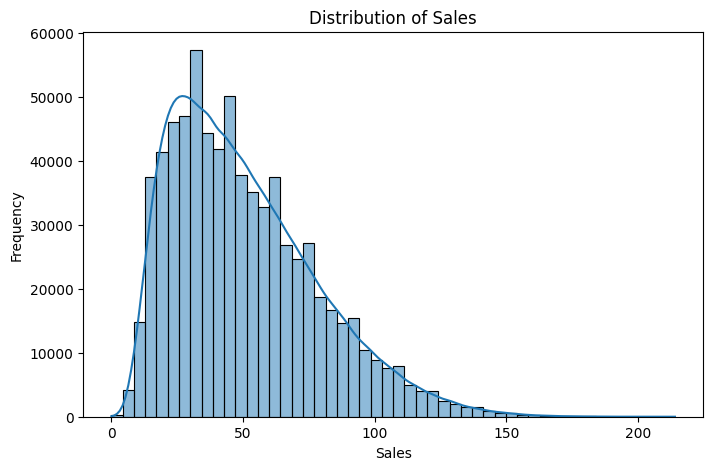

In [12]:
# Sales distribution
plt.figure(figsize=(8,5))
sns.histplot(eda_df["sales"], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.savefig("distribution_of_sales.png")
plt.show()

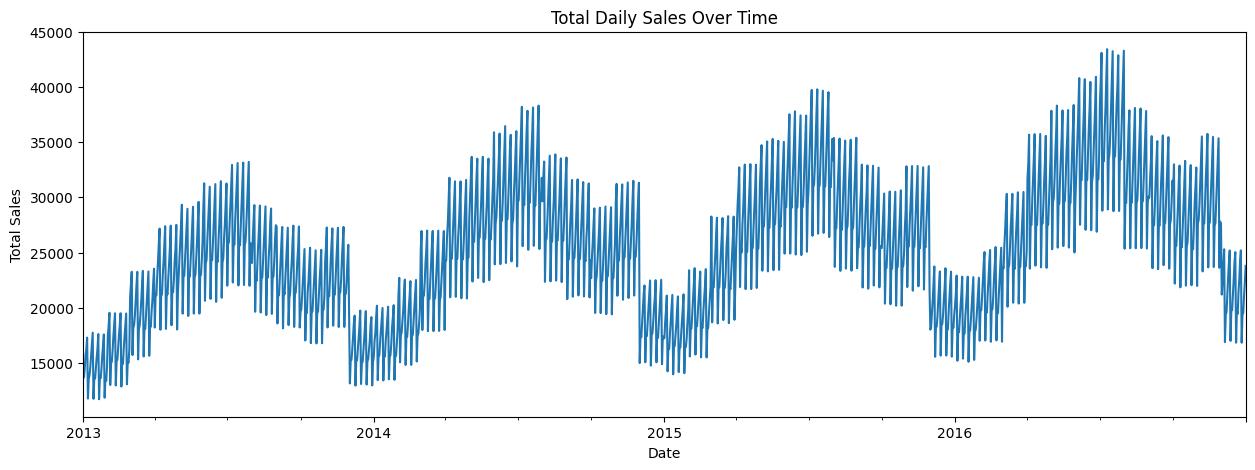

In [13]:
# Average sales over time
daily_sales = eda_df.groupby("date")["sales"].sum()
plt.figure(figsize=(15,5))
daily_sales.plot()
plt.title("Total Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.savefig("total_daily_sales.png")
plt.show()

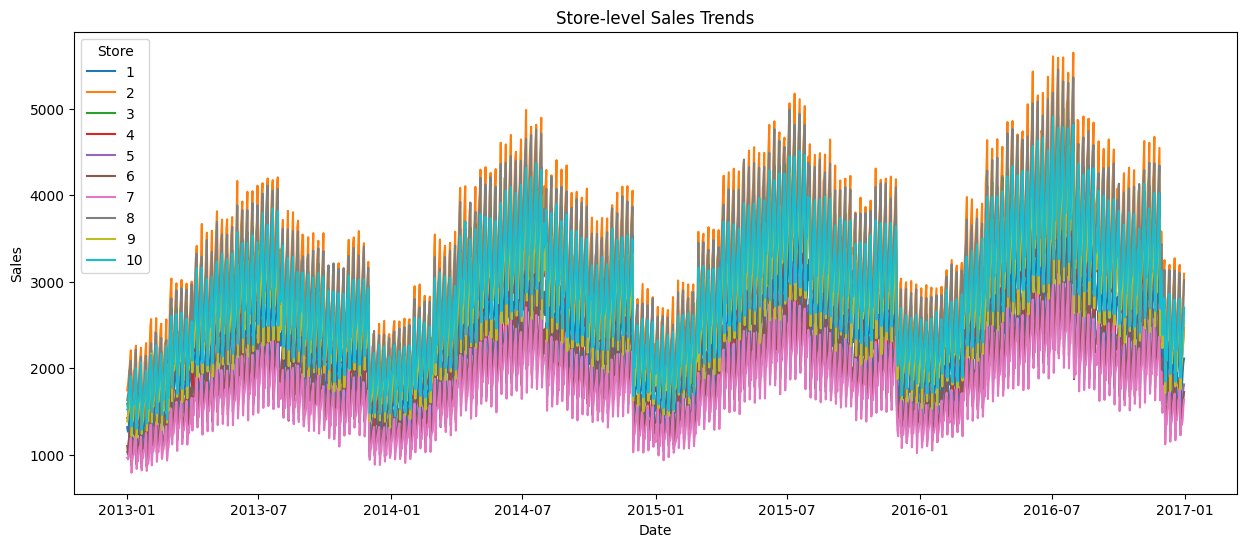

In [14]:
# Store-level sales trends
store_sales = eda_df.groupby(["date", "store"])["sales"].sum().reset_index()
plt.figure(figsize=(15,6))
sns.lineplot(data=store_sales, x="date", y="sales", hue="store", palette="tab10")
plt.title("Store-level Sales Trends")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend(title="Store")
plt.savefig("store_level_sales.png")
plt.show()

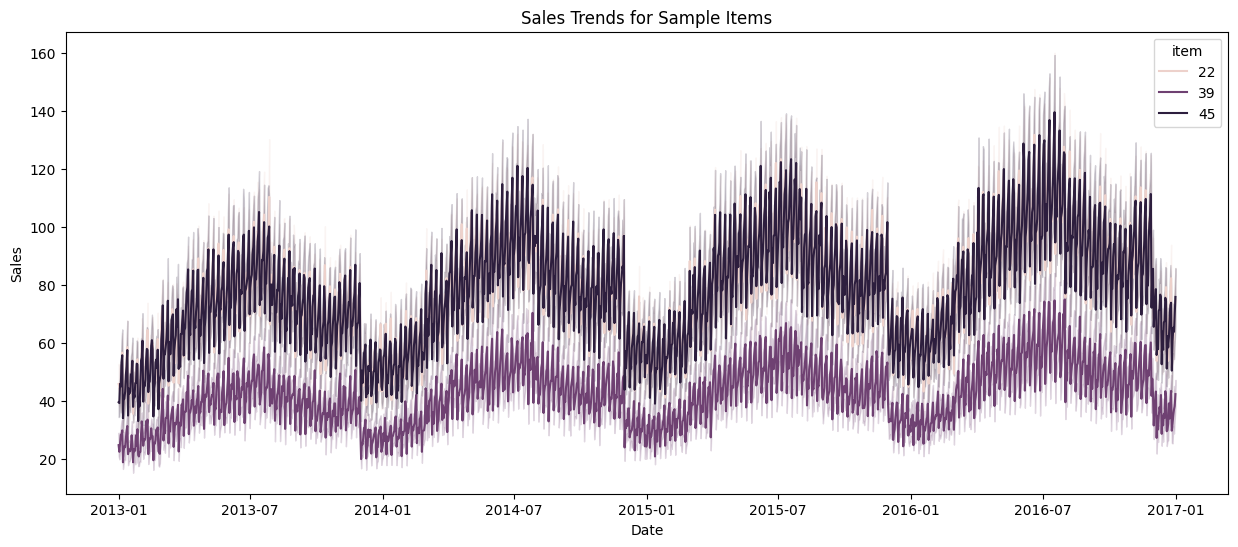

In [15]:
# Item-level sales distribution (sample of few items)
sample_items = eda_df["item"].sample(5, random_state=42).unique()
item_sales = eda_df[eda_df["item"].isin(sample_items)]
plt.figure(figsize=(15,6))
sns.lineplot(data=item_sales, x="date", y="sales", hue="item")
plt.title("Sales Trends for Sample Items")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.savefig("sales_trends_sample_items.png")
plt.show()

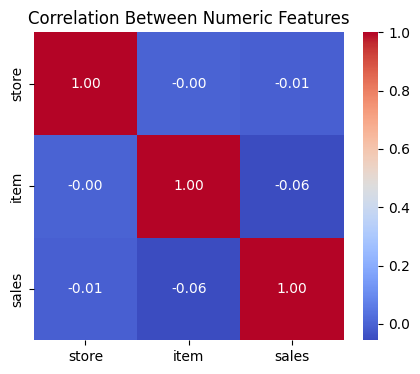

In [16]:
# Check for Correlation
corr = eda_df[["store", "item", "sales"]].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.savefig("correlation.png")
plt.show()

## **Data Processing**

Before modeling, the raw data must be transformed to fit time series requirements.
We first checked for stationarity using the Augmented Dickey-Fuller test. Since the series was non-stationary, we applied log transformation and differencing, which successfully made it stationary. This ensures the data can be used in classical forecasting models such as ARIMA.

For machine learning approaches, we went further by enriching the dataset with calendar-based features (year, month, day, dayofweek, weekofyear, weekend flag) and scaling the raw sales values. At the store–item level, we kept both the transformed series (log_sales, sales_diff) and engineered features so the dataset works consistently across both classical and ML models.

To make this process repeatable, we wrapped all transformations into a single preprocessing function. The same steps (date parsing, sorting, log transform, differencing, time features, scaling) are applied consistently to train, validation, and test sets. The scaler is fit only on the training set to avoid leakage and then reused for validation and test.

Finally, we created lag and rolling-window features from the transformed series (log_sales). These capture short- and medium-term dependencies (e.g., yesterday’s sales, last week’s sales, rolling averages), which are essential for predictive performance. After generating these features, the data was split back into train, validation, and test sets, and X, y matrices were built for model training.

In [17]:
# Import libraries
import numpy as np
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler

In [18]:
# Define function to check for stationarity
def check_stationarity(series, signif=0.05, name="Series"):
    """
    Perform Agmented Dickey-Fuller test to check stationarity.
    """
    result = adfuller(series, autolag="AIC")
    p_value = result[1]
    print(f"ADF Test for {name}")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {p_value:.4f}")
    if p_value <= signif:
        print("Series is stationary\n")
    else:
        print("Series is non-stationary\n")
    return p_value <= signif

In [19]:
# Use a copy of the data
prep_df = train_data.copy()

In [20]:
# Aggregate total daily sales across all stores/items
daily_sales = prep_df.groupby("date")["sales"].sum()

# Run stationarity test
check_stationarity(daily_sales, name="Total Daily Sales")

ADF Test for Total Daily Sales
ADF Statistic: -2.8367
p-value: 0.0532
Series is non-stationary



np.False_

Since the p-value (0.0532) is greater than 0.05, we cannot reject the null hypothesis that the series has a unit root (non-stationary).

So we will apply log transformation and differencing to make the data stationary

In [21]:
# Apply log transformation to stabilize variance
log_sales = np.log1p(daily_sales)

In [22]:
# Apply first differencing to remove trend
diff_sales = log_sales.diff().dropna()

print("Check stationarity after log + differencing:")
check_stationarity(diff_sales, name="Differenced Log Sales")

Check stationarity after log + differencing:
ADF Test for Differenced Log Sales
ADF Statistic: -7.8084
p-value: 0.0000
Series is stationary



np.True_

Since the p-value (0.0000) is less than the significance level of 0.05, we reject the null hypothesis and accept the alternative hypothesis that the time series does not have a unit root (stationary)

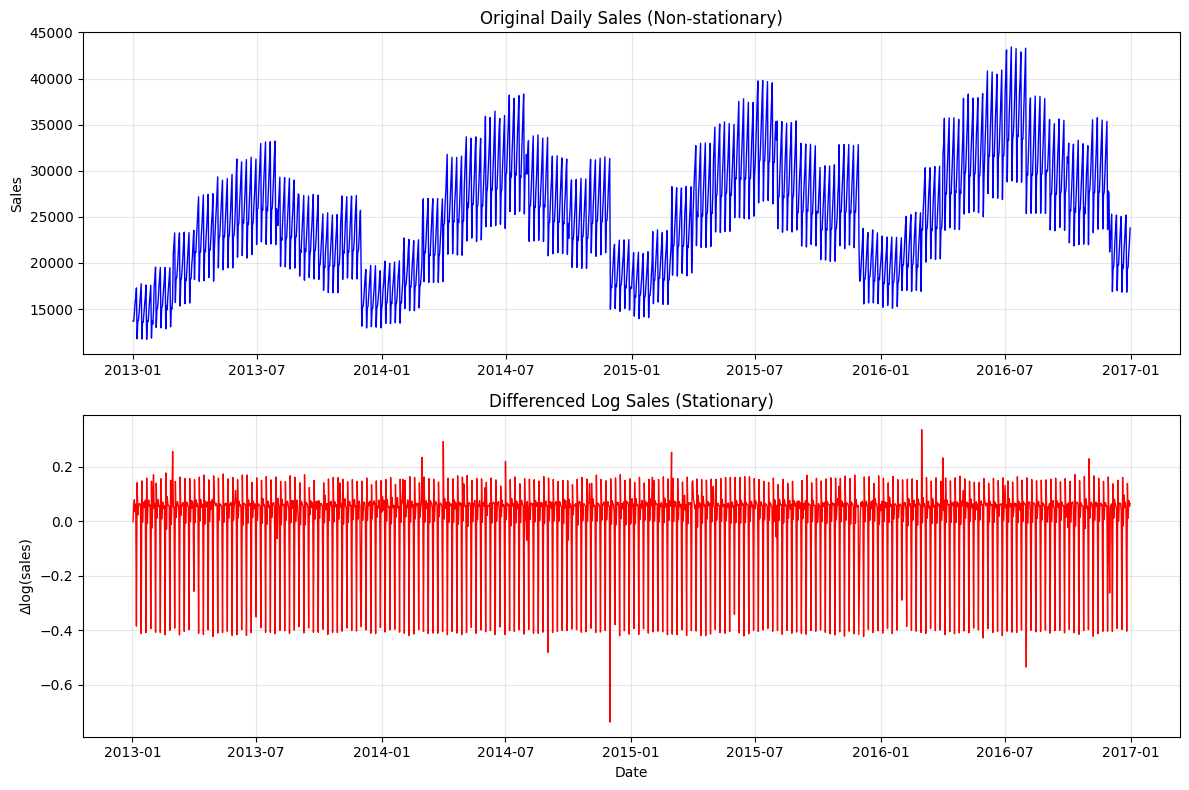

In [23]:
# Visualize the sales and stationary data

# Plot original sales
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(daily_sales.index, daily_sales.values, color="blue", linewidth=1)
plt.title("Original Daily Sales (Non-stationary)")
plt.ylabel("Sales")
plt.grid(True, alpha=0.3)

# Plot differenced log sales (stationary)
plt.subplot(2,1,2)
plt.plot(diff_sales.index, diff_sales.values, color="red", linewidth=1)
plt.title("Differenced Log Sales (Stationary)")
plt.ylabel('Δlog(sales)')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("differenced_log_sales.png")
plt.show()

In [24]:
# Add transformed features back to the data
prep_df = prep_df.sort_values(["store", "item", "date"]).copy()

# Log transform of sales
prep_df["log_sales"] = np.log1p(prep_df["sales"])

# Differencing at store-item level to preserve structure for ARIMA/ML
prep_df["sales_diff"] = (
    prep_df.groupby(["store", "item"])["log_sales"].diff()
)

In [25]:
# Create time-based features for ML

def create_time_features(df):
    df = df.copy()
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    return df

prep_df = create_time_features(prep_df)

In [26]:
# Scale sales for ML models

scaler = StandardScaler()
prep_df["sales_scaled"] = scaler.fit_transform(prep_df[["sales"]])

In [27]:
# Check the data
print("Processed training data shape:", prep_df.shape)
display(prep_df.head(10))

Processed training data shape: (730500, 13)


,date,store,item,sales,log_sales,sales_diff,year,month,day,dayofweek,weekofyear,is_weekend,sales_scaled
0,2013-01-01,1,1,13,2.639057,NaN,2013,1,1,1,1,0,-1.351382
1,2013-01-02,1,1,11,2.484907,-0.154151,2013,1,2,2,1,0,-1.423244
2,2013-01-03,1,1,14,2.708050,0.223144,2013,1,3,3,1,0,-1.315450
3,2013-01-04,1,1,13,2.639057,-0.068993,2013,1,4,4,1,0,-1.351382
4,2013-01-05,1,1,10,2.397895,-0.241162,2013,1,5,5,1,1,-1.459175
5,2013-01-06,1,1,12,2.564949,0.167054,2013,1,6,6,1,1,-1.387313
6,2013-01-07,1,1,10,2.397895,-0.167054,2013,1,7,0,2,0,-1.459175
7,2013-01-08,1,1,9,2.302585,-0.095310,2013,1,8,1,2,0,-1.495107
8,2013-01-09,1,1,12,2.564949,0.262364,2013,1,9,2,2,0,-1.387313
9,2013-01-10,1,1,9,2.302585,-0.262364,2013,1,10,3,2,0,-1.495107


**Wrap up these preprocessing steps in a function, so it can be applied across our train, val and test set**

In [28]:
# Define preprocessing function
def preprocess_data(df, scaler=None, fit_scaler=False):
    """
      - Convert date to datetime
      - Sort by store,item,date
      - Create time features
      - If `sales` exists: create log_sales, sales_diff (groupwise)
      - Scale `sales` using StandardScaler (fit only if fit_scaler=True)

    Returns:
      df (pd.DataFrame) : transformed dataframe with new columns
      scaler (StandardScaler or None)
    """
    df = df.copy()

    # Ensure datetime
    df["date"] = pd.to_datetime(df["date"])

    # Sort for group operations
    df = df.sort_values(["store", "item", "date"]).reset_index(drop=True)

    # Add time features
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofweek"] = df["date"].dt.dayofweek
    df["weekofyear"] = df["date"].dt.isocalendar().week.astype(int)
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)

    # If sales present, create log and diff features
    if "sales" in df.columns:
        # log transform
        df["log_sales"] = np.log1p(df["sales"])

        # Group-wise differencing
        df["sales_diff"] = df.groupby(["store", "item"])["log_sales"].diff()

        # Scale raw sales for ML models
        if scaler is None:
            scaler = StandardScaler()
        if fit_scaler:
            df["sales_scaled"] = scaler.fit_transform(df[["sales"]])
        else:
            df["sales_scaled"] = scaler.transform(df[["sales"]])
    else:
          scaler = scaler

    return df, scaler

In [29]:
# Create lag and rolling feature
def create_lag_rolling_features(df, lags=[1,7,14,28], roll_windows=[7,14,28], target_col="lag_sales"):
    """
    Add lag_n and rolling_mean_w features based on `target_col`.
    Uses groupby by (store, item) and shift/rolling so no leakage occurs.
    """
    df = df.copy()
    df = df.sort_values(["store", "item", "date"]).reset_index(drop=True)

    # Lags
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(["store", "item"])[target_col].shift(lag)

    # Rolling means
    for w in roll_windows:
        df[f"rolling_mean_{w}"] = df.groupby(["store", "item"])[target_col] \
                                      .transform(lambda x: x.shift(1).rolling(window=w, min_periods=1).mean())

    return df

In [30]:
# Define X, y builder
def build_X_y(df, feature_cols, target_col="sales"):
    """
    Given a dataframe with features (including lag features), return X, y.
    Drops rows with NaNs in any of the chosen feature_cols or the target (to avoid training on incomplete rows).
    For test (no target_col), returns X and y=None.
    """
    df = df.copy()

    if target_col in df.columns:
        # drop rows where any feature or target is NaN
        keep = df.dropna(subset=feature_cols + [target_col])
        X = keep[feature_cols].reset_index(drop=True)
        y = keep[target_col].reset_index(drop=True)
        return X, y
    else:
        # Test data: drop rows any feature is Nan, return X only
        keep = df.dropna(how="all", subset=feature_cols)
        X = keep[feature_cols].reset_index(drop=True)
        return X, None

In [31]:
# Preprocess train/val/test with same preprocess function
train_proc, scaler = preprocess_data(train_data, scaler=None, fit_scaler=True)
val_proc, _ = preprocess_data(val_data, scaler=scaler, fit_scaler=False)
test_proc, _ = preprocess_data(test, scaler=scaler, fit_scaler=False)

In [32]:
# Display few rows of preprocessed train data
print(train_proc.head())

        date  store  item  sales  year  month  day  dayofweek  weekofyear  \
0 2013-01-01      1     1     13  2013      1    1          1           1   
1 2013-01-02      1     1     11  2013      1    2          2           1   
2 2013-01-03      1     1     14  2013      1    3          3           1   
3 2013-01-04      1     1     13  2013      1    4          4           1   
4 2013-01-05      1     1     10  2013      1    5          5           1   

   is_weekend  log_sales  sales_diff  sales_scaled  
0           0   2.639057         NaN     -1.351382  
1           0   2.484907   -0.154151     -1.423244  
2           0   2.708050    0.223144     -1.315450  
3           0   2.639057   -0.068993     -1.351382  
4           1   2.397895   -0.241162     -1.459175  


In [33]:
# Mark dataset origin, concatenate so lag features can compute across boundary correctly
train_proc["__set__"] = "train"
val_proc["__set__"]   = "val"
test_proc["__set__"]  = "test"

combined = pd.concat([train_proc, val_proc, test_proc], axis=0, ignore_index=True)
combined = combined.sort_values(["store", "item", "date"]).reset_index(drop=True)

In [34]:
# Display first 5 rows of combined data
print(combined.head())

        date  store  item  sales  year  month  day  dayofweek  weekofyear  \
0 2013-01-01      1     1   13.0  2013      1    1          1           1   
1 2013-01-02      1     1   11.0  2013      1    2          2           1   
2 2013-01-03      1     1   14.0  2013      1    3          3           1   
3 2013-01-04      1     1   13.0  2013      1    4          4           1   
4 2013-01-05      1     1   10.0  2013      1    5          5           1   

   is_weekend  log_sales  sales_diff  sales_scaled __set__  id  
0           0   2.639057         NaN     -1.351382   train NaN  
1           0   2.484907   -0.154151     -1.423244   train NaN  
2           0   2.708050    0.223144     -1.315450   train NaN  
3           0   2.639057   -0.068993     -1.351382   train NaN  
4           1   2.397895   -0.241162     -1.459175   train NaN  


In [35]:
# Create lag + rolling features on combined
combined = create_lag_rolling_features(combined, lags=[1,7,14,28], roll_windows=[7,14,28], target_col="log_sales")

In [36]:
# View combined data
print(combined.head())

        date  store  item  sales  year  month  day  dayofweek  weekofyear  \
0 2013-01-01      1     1   13.0  2013      1    1          1           1   
1 2013-01-02      1     1   11.0  2013      1    2          2           1   
2 2013-01-03      1     1   14.0  2013      1    3          3           1   
3 2013-01-04      1     1   13.0  2013      1    4          4           1   
4 2013-01-05      1     1   10.0  2013      1    5          5           1   

   is_weekend  ...  sales_scaled  __set__  id     lag_1  lag_7  lag_14  \
0           0  ...     -1.351382    train NaN       NaN    NaN     NaN   
1           0  ...     -1.423244    train NaN  2.639057    NaN     NaN   
2           0  ...     -1.315450    train NaN  2.484907    NaN     NaN   
3           0  ...     -1.351382    train NaN  2.708050    NaN     NaN   
4           1  ...     -1.459175    train NaN  2.639057    NaN     NaN   

   lag_28  rolling_mean_7  rolling_mean_14  rolling_mean_28  
0     NaN             NaN     

In [37]:
# Split back
train_lag = combined[combined["__set__"] == "train"].reset_index(drop=True)
val_lag   = combined[combined["__set__"] == "val"].reset_index(drop=True)
test_lag  = combined[combined["__set__"] == "test"].reset_index(drop=True)

In [38]:
# Check columns in train
train_lag.columns

Index(['date', 'store', 'item', 'sales', 'year', 'month', 'day', 'dayofweek',
       'weekofyear', 'is_weekend', 'log_sales', 'sales_diff', 'sales_scaled',
       '__set__', 'id', 'lag_1', 'lag_7', 'lag_14', 'lag_28', 'rolling_mean_7',
       'rolling_mean_14', 'rolling_mean_28'],
      dtype='object')

In [39]:
# Choose features and we will not include "sales" or "log_sales" as input features
features = [
    "store", "item", "year", "month",
    "dayofweek", "is_weekend", "weekofyear",
    "lag_1", "lag_7","lag_14", "lag_28", "rolling_mean_7",
    "rolling_mean_14","rolling_mean_28"
]

# Build training X,y
X_train, y_train = build_X_y(train_lag, feature_cols=features, target_col="sales")
X_val, y_val = build_X_y(val_lag, feature_cols=features, target_col="sales")
X_test, _ = build_X_y(test_lag, feature_cols=features, target_col=None)

In [40]:
# Quick check
print("X_train shape:", X_train.shape, "y_train shape:", None if y_train is None else y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", None if y_val is None else y_val.shape)
print("X_test shape:", X_test.shape)

# Display few rows in train set
display(X_train.head())
display(y_train.head())

X_train shape: (716500, 14) y_train shape: (716500,)
X_val shape: (182500, 14) y_val shape: (182500,)
X_test shape: (45000, 14)


,store,item,year,month,dayofweek,is_weekend,weekofyear,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28
0,1,1,2013,1,1,0,5,2.484907,2.079442,1.791759,2.639057,2.414587,2.400015,2.426679
1,1,1,2013,1,2,0,5,1.945910,2.302585,2.079442,2.484907,2.395511,2.411026,2.401924
2,1,1,2013,1,3,0,5,2.302585,2.197225,2.833213,2.708050,2.395511,2.426965,2.395412
3,1,1,2013,2,4,0,5,2.639057,2.708050,2.079442,2.639057,2.458630,2.413097,2.392948
4,1,1,2013,2,5,1,5,2.484907,2.564949,2.944439,2.397895,2.426752,2.442058,2.387443


,sales
0,6.0
1,9.0
2,13.0
3,11.0
4,21.0


In [41]:
# Display few rows in validation set
display(X_val.head())
display(y_val.head())

,store,item,year,month,dayofweek,is_weekend,weekofyear,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28
0,1,1,2017,1,6,1,52,2.708050,3.044522,3.135494,3.218876,2.875259,2.888335,2.804234
1,1,1,2017,1,0,0,1,2.995732,2.833213,2.890372,2.639057,2.868289,2.878352,2.796265
2,1,1,2017,1,1,0,1,2.772589,2.397895,2.944439,2.397895,2.859628,2.869939,2.801034
3,1,1,2017,1,2,0,1,2.397895,2.833213,2.564949,2.890372,2.859628,2.830900,2.801034
4,1,1,2017,1,3,0,1,2.833213,3.091042,3.044522,2.772589,2.859628,2.850062,2.798992


,sales
0,19.0
1,15.0
2,10.0
3,16.0
4,14.0


In [42]:
# Display few rows in test set
display(X_test.head())

,store,item,year,month,dayofweek,is_weekend,weekofyear,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28
0,1,1,2018,1,0,0,1,3.178054,2.639057,2.995732,2.079442,2.922700,2.772737,2.823839
1,1,1,2018,1,1,0,1,NaN,2.833213,2.079442,3.044522,2.969974,2.755584,2.851409
2,1,1,2018,1,2,0,1,NaN,2.708050,2.833213,2.890372,2.997326,2.811929,2.843982
3,1,1,2018,1,3,0,1,NaN,2.995732,2.564949,2.944439,3.069645,2.809994,2.842126
4,1,1,2018,1,4,0,1,NaN,2.772589,1.945910,2.890372,3.094282,2.834498,2.837863


In [43]:
# Fill NaN with mean
X_test = X_test.fillna(X_train.mean())

In [44]:
# Display the first 5 rows
display(X_test.head())

,store,item,year,month,dayofweek,is_weekend,weekofyear,lag_1,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28
0,1,1,2018,1,0,0,1,3.178054,2.639057,2.995732,2.079442,2.922700,2.772737,2.823839
1,1,1,2018,1,1,0,1,3.799350,2.833213,2.079442,3.044522,2.969974,2.755584,2.851409
2,1,1,2018,1,2,0,1,3.799350,2.708050,2.833213,2.890372,2.997326,2.811929,2.843982
3,1,1,2018,1,3,0,1,3.799350,2.995732,2.564949,2.944439,3.069645,2.809994,2.842126
4,1,1,2018,1,4,0,1,3.799350,2.772589,1.945910,2.890372,3.094282,2.834498,2.837863


## **Modeling**

Forecasting performance is best evaluated by starting with simple baselines and gradually moving toward more complex models.
We begin with naive approaches (mean/last value) as sanity checks, then move to classical statistical models like ARIMA, and then explore machine learning models that use lag and rolling features. This stepwise approach helps benchmark progress and prevents overfitting by showing how much each added complexity improves accuracy.

In [45]:
# Import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Define evaluation function
def evaluate_forecast(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{model_name} -> RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    return rmse, mae

In [46]:
# Function for plot of actual vs predicted
def plot_forecast(y_true, y_pred, dates, title="Forecast vs Actual"):
    plt.figure(figsize=(12,6))
    plt.plot(dates, y_true, label="Actual", color="blue")
    plt.plot(dates, y_pred, label="Predicted", color="red")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.savefig(f"{title}.png")
    plt.show()

### **Baseline Models**

In [47]:
# Naive forecast (last value)
def naive_forecast(y_train, y_val):
    y_pred = [y_train.iloc[-1]] * len(y_val)
    return y_pred

# Mean Forecast
def mean_forecast(y_train, y_val):
    y_pred = [y_train.mean()] * len(y_val)
    return y_pred

In [48]:
# Run baseline models
naive_pred = naive_forecast(y_train, y_val)
mean_pred = mean_forecast(y_train, y_val)

In [49]:
# Evaluate models
evaluate_forecast(y_val, naive_pred, "Naive Forecast")
evaluate_forecast(y_val, mean_pred, "Mean Forecast")

Naive Forecast -> RMSE: 31.98, MAE: 26.49
Mean Forecast -> RMSE: 32.50, MAE: 25.26


(np.float64(32.50059482651978), 25.26005018821707)

Baselines show similar performance (RMSE: ~32), with Mean forecast slightly better on MAE

Both capture the general level but miss daily variations - room for significant improvement

ARIMA/SARIMA models should outperform these simple benchmarks

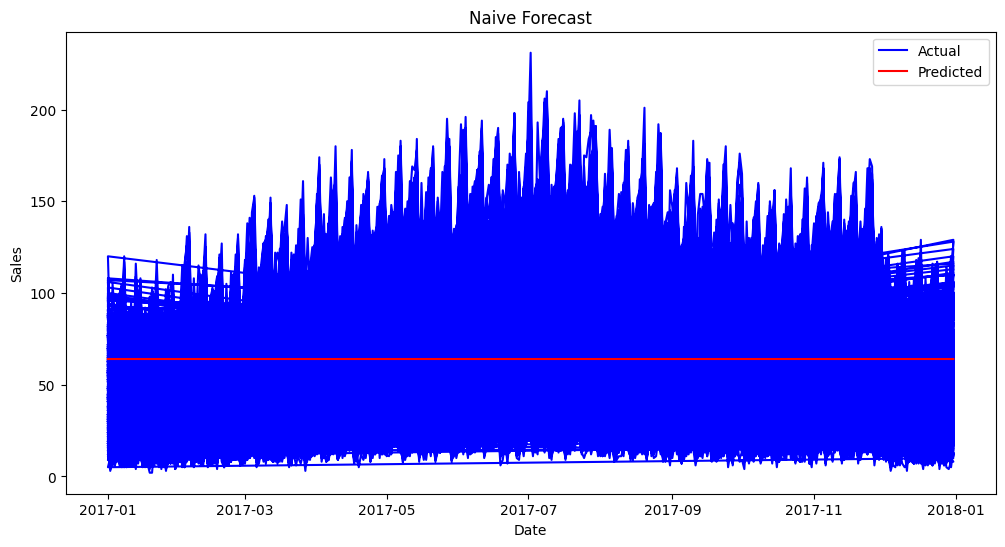

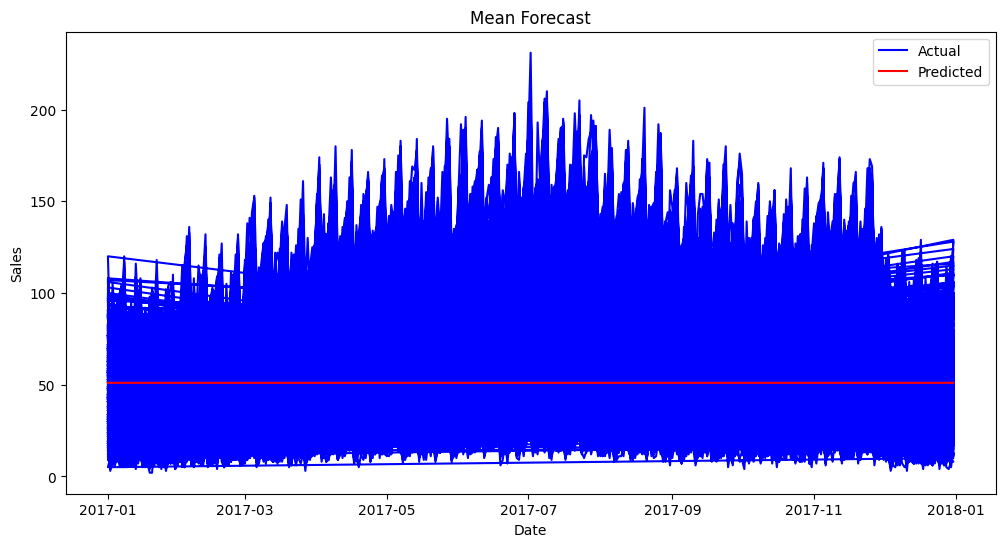

In [50]:
# Plot predictions
plot_forecast(y_val, naive_pred, val_lag["date"], "Naive Forecast")
plot_forecast(y_val, mean_pred, val_lag["date"], "Mean Forecast")

In [51]:
# Visualize first 200 predictions
def plot_baseline_predictions(y_val, naive_pred, mean_pred, n=200):
    """
    Compare baseline predictions with actual values.
    Arguments:
        y_val (pd.Series or np.array): actual validation targets
        naive_pred (array): naive forecast predictions
        mean_pred (array): mean forecast predictions
        n (int): number of points to plot (for clarity)
    """
    plt.figure(figsize=(12,6))
    plt.plot(y_val[:n].reset_index(drop=True), label="Actual", color="black", linewidth=2)
    plt.plot(naive_pred[:n], label="Naive Forecast", color="blue", linestyle="--")
    plt.plot(mean_pred[:n], label="Mean Forecast", color="red", linestyle="--")
    plt.title(f"Baseline Forecasts vs Actuals (first {n} validation points)")
    plt.xlabel("Time steps")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.savefig("baseline_models.png")
    plt.show()

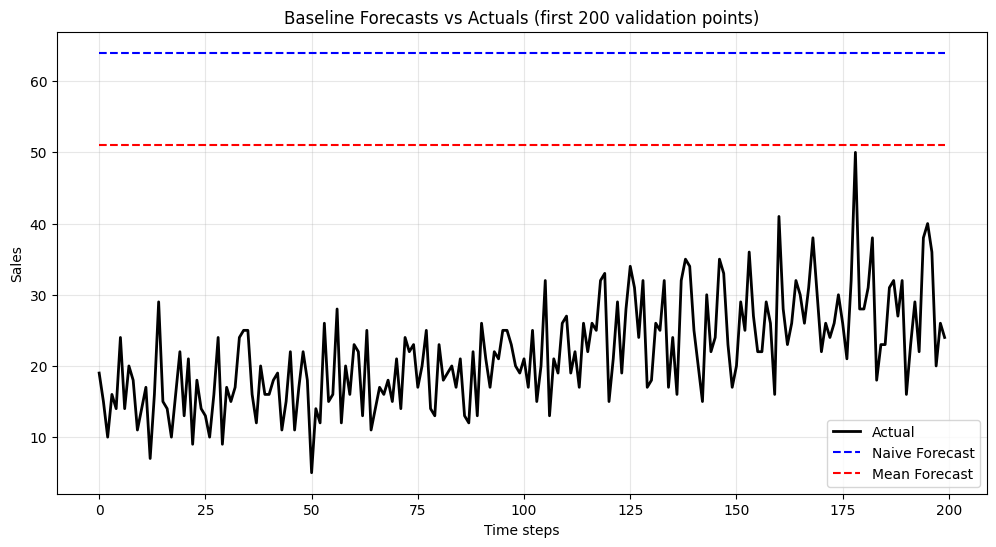

In [52]:
# Run baselines
plot_baseline_predictions(y_val, naive_pred, mean_pred, n=200)

### **ARIMA Model**

In [53]:
# Import ARIMA Model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [54]:
# Function to fit Arima
def fit_arima(train_series, order=(1,1,1)):
    model = ARIMA(train_series, order=order)
    fitted = model.fit()
    return fitted

In [55]:
# Aggregate daily sales for ARIMA
daily_train = train_data.groupby("date")["sales"].sum()
daily_val = val_data.groupby("date")["sales"].sum()

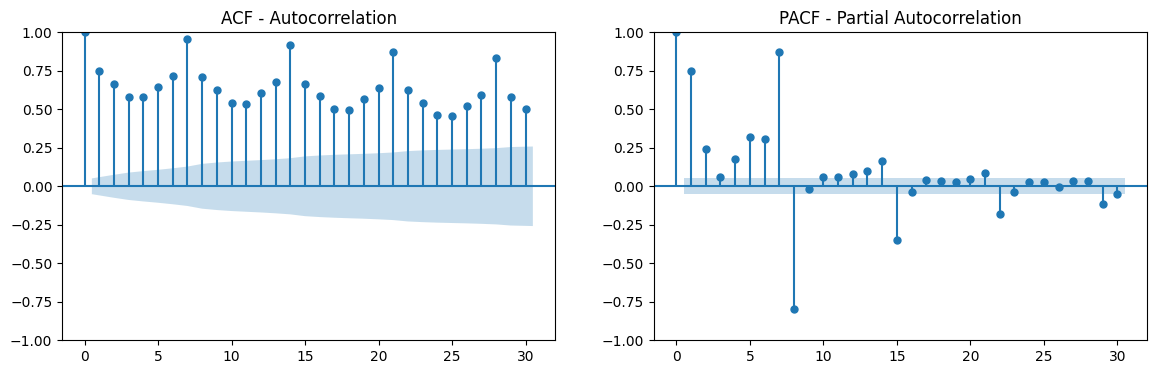

In [56]:
# Plot ACF and PACF to select (p, d)
fig, axes = plt.subplots(1,2, figsize=(14,4))
plot_acf(daily_train.dropna(), lags=30, ax=axes[0])
axes[0].set_title("ACF - Autocorrelation")
plot_pacf(daily_train.dropna(), lags=30, ax=axes[1], method="ywm")
axes[1].set_title("PACF - Partial Autocorrelation")
plt.savefig("pacf_acf.png")
plt.show()

Step 1: Look at stationarity (d)
- The ACF decays slowly (still high after 20+ lags).
- This might be a red flag for non-stationarity.
- Likely need d = 1 (first differencing).

Step 2: Look at AR part (p) → PACF
- PACF shows a strong spike at lag 1, smaller ones at lags 2–3, then dies down.
- This suggests AR(1) or maybe AR(2).
- Candidate p = 1 (or 2).

Step 3: Look at MA part (q) → ACF
- ACF has many significant positive lags (no sharp cut-off).
- Strong spike at lag 1, then slowly decays.
- This points to an MA(1) component.
- Candidate q = 1 (or possibly 2).

Best order for arima models from this plot:
- ARIMA(1,1,1)
- ARIMA(2,1,1)
- ARIMA(2,1,2)

In [57]:
# Confirm and check for best ARIMA order
for order in [(1,1,1), (2,1,1), (2,1,2)]:
    model = ARIMA(daily_train, order=order)
    fitted = model.fit()
    print(f"Order {order} -> AIC: {fitted.aic}, BIC: {fitted.bic}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Order (1, 1, 1) -> AIC: 28034.542262694915, BIC: 28050.40083783902


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

Order (2, 1, 1) -> AIC: 28056.072208826503, BIC: 28077.21697568531


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

Order (2, 1, 2) -> AIC: 27870.91618577337, BIC: 27897.347144346884


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


The lowest AIC/BIC is always better

Here, ARIMA(2,1,2) is clearly best (≈ 160 points lower than (1,1,1)

We will go with ARIMA(2,1,2)

In [58]:
# Fit ARIMA model
arima_model = fit_arima(daily_train, order=(2,1,2))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

In [59]:
# Forecast validation period
arima_forecast = arima_model.forecast(steps=len(daily_val))

In [60]:
# Evaluate ARIMA model
evaluate_forecast(daily_val, arima_forecast, "ARIMA")

ARIMA -> RMSE: 10075.41, MAE: 8376.17


(np.float64(10075.406365066818), 8376.172464832498)

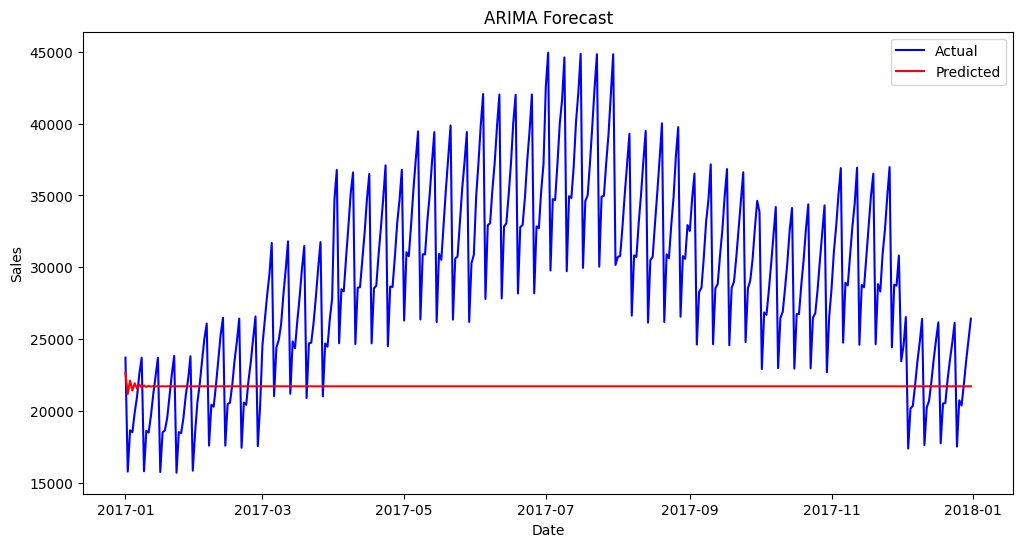

In [61]:
# Plot ARIMA results
plot_forecast(daily_val, arima_forecast, daily_val.index, "ARIMA Forecast")

ARIMA model shows high error (RMSE: ~10,075), indicating room for improvement

The forecast captures trend but likely misses seasonal patterns

Next, we'll try SARIMA to incorporate seasonal components for better accuracy

### **SARIMA Model**

In [62]:
# import sarimax model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function to fit SARIMA
def fit_sarima(train_series, order=(2,1,2), seasonal_order=(1,1,1,7)):
    model = SARIMAX(train_series, order=order,
                    seasonal_order=seasonal_order,
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    fitted = model.fit(disp=False)
    return fitted

In [63]:
# Seasonal orders to try
candidate_sarima = [
    ((2,1,2), (1,1,1,7)),
    ((2,1,2), (0,1,1,7)),
    ((2,1,2), (1,0,1,7))
]

# Loop through and check AIC/BIC
for order, seasonal in candidate_sarima:
    model = SARIMAX(daily_train, order=order,
                    seasonal_order=seasonal,
                    enforce_stationarity=False,
                    enforce_indertibility=False)
    fitted = model.fit(disp=False)
    print(f"Order={order}, Seasonal={seasonal} -> AIC: {fitted.aic:.2f}, BIC: {fitted.bic:.2f}")

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['enforce_indertibility']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Order=(2, 1, 2), Seasonal=(1, 1, 1, 7) -> AIC: 23330.66, BIC: 23367.59


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['enforce_indertibility']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueW

Order=(2, 1, 2), Seasonal=(0, 1, 1, 7) -> AIC: 23296.08, BIC: 23327.72
Order=(2, 1, 2), Seasonal=(1, 0, 1, 7) -> AIC: 25088.57, BIC: 25125.52


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2,1,2)(0,1,1,7) shows best performance (lowest AIC: 23296.08)

Seasonal differencing (D=1) with weekly period (s=7) significantly improves model fit

In [64]:
# Fit SARIMA
sarima_model = fit_sarima(daily_train, order=(2,1,2), seasonal_order=(1,1,1,7))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
# Forecast validation period
sarima_forecast = sarima_model.forecast(steps=len(daily_val))

In [66]:
# Evaluate SARIMA
evaluate_forecast(daily_val, sarima_forecast, "SARIMA Model")

SARIMA Model -> RMSE: 10833.98, MAE: 9412.99


(np.float64(10833.978380947165), 9412.993957737646)

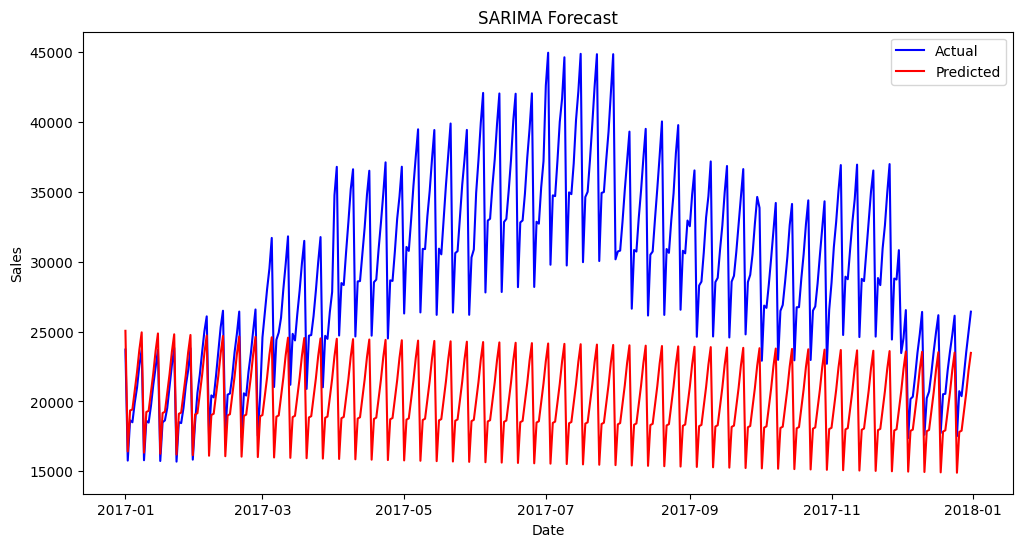

In [67]:
# Plot results
plot_forecast(daily_val,sarima_forecast, daily_val.index, "SARIMA Forecast")

SARIMA shows higher error (RMSE: 10,834) than ARIMA (RMSE: 10,075) - unexpected performance drop.

Despite better AIC score, SARIMA may be overfitting or seasonal components need tuning.

ARIMA currently performs better, suggesting simpler model might be more robust for this data

### **Machine Learning Forecasting**

Now we move to machine learning models.

Unlike ARIMA/SARIMA that directly model the time series, ML models treat forecasting as a supervised learning problem. We use engineered features (calendar variables, lags, scaling) to predict sales. This allows capturing nonlinear patterns and interactions.

In [68]:
# Define evaluate function
def evaluate_ml_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Fit model, predict validation set, evaluate and plot.
    """
    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    # Evaluate
    mae = mean_absolute_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Plot
    plt.figure(figsize=(12,5))
    plt.plot(y_val[:200].values, label="Actuals", color="blue")
    plt.plot(preds[:200], label="Predicted", color="red")
    plt.title(f"{model_name} Predictions vs Actual (first 200 points)")
    plt.legend()
    plt.savefig(f"{model_name}.png")
    plt.show()

    return preds

In [69]:
# Import machine learning models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

Linear Regression - MAE: 9.5913, RMSE: 12.9023


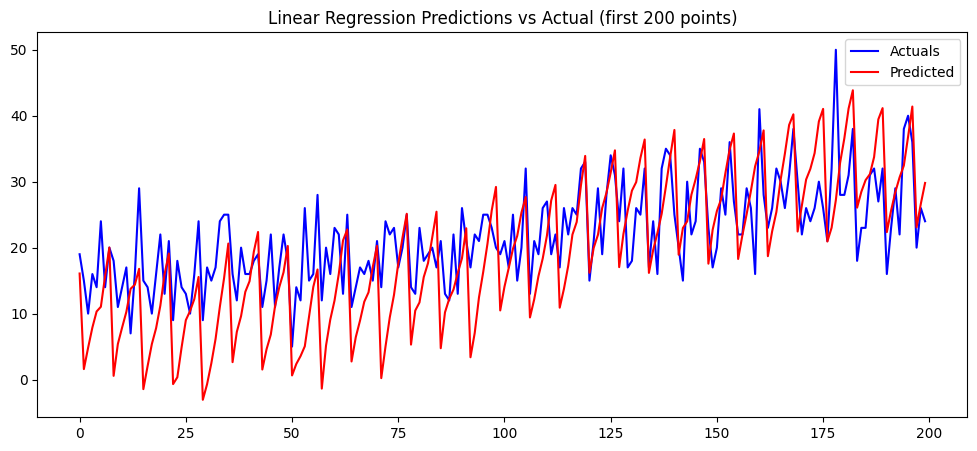

In [70]:
# Linear Regression
lin_reg = LinearRegression()
lin_preds = evaluate_ml_model(lin_reg, X_train, y_train, X_val, y_val, "Linear Regression")

Ridge Regression - MAE: 9.5913, RMSE: 12.9023


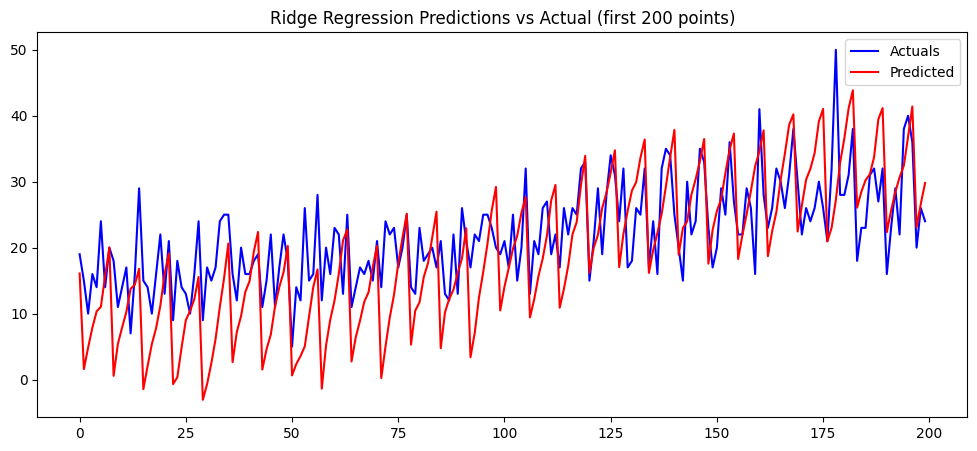

In [71]:
# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge_preds = evaluate_ml_model(ridge, X_train, y_train, X_val, y_val, "Ridge Regression")

Random Forest - MAE: 6.7809, RMSE: 8.9324


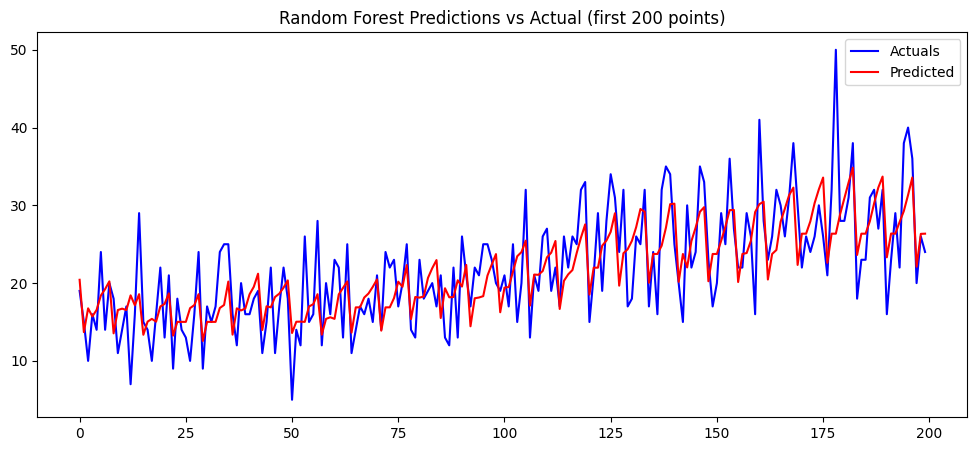

In [72]:
# Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=8,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_preds = evaluate_ml_model(rf, X_train, y_train, X_val, y_val, "Random Forest")

XGBoost - MAE: 6.1186, RMSE: 7.9502


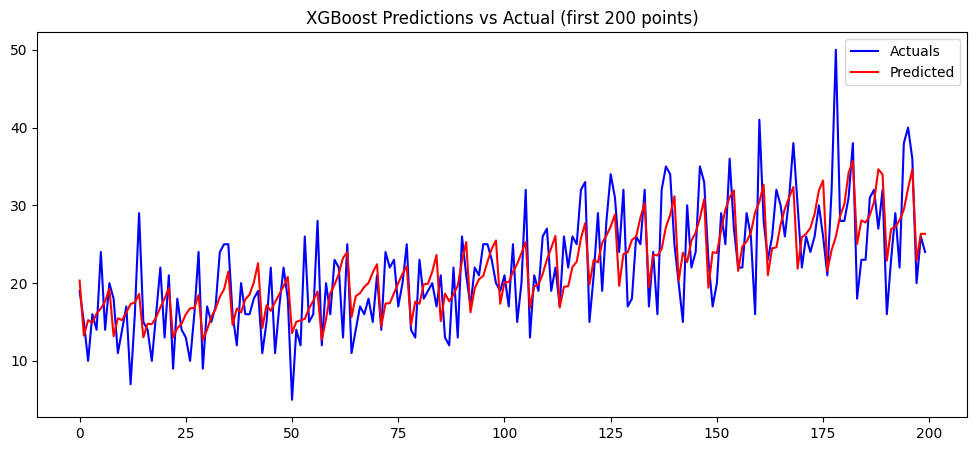

In [73]:
# XGBoost
xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)
xgb_preds = evaluate_ml_model(xgb, X_train, y_train, X_val, y_val, "XGBoost")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078693 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1639
[LightGBM] [Info] Number of data points in the train set: 716500, number of used features: 14
[LightGBM] [Info] Start training from score 51.022620
LightGBM - MAE: 6.1257, RMSE: 7.9548


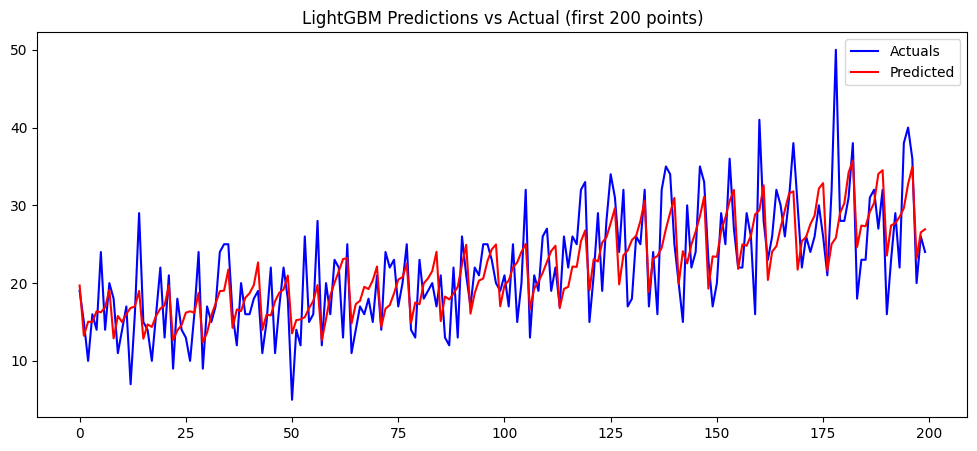

In [74]:
# LightGBM
lgbm = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,
    subsample=0.7,
    colsample_bytree=0.7,
    random_state=42,
    n_jobs=-1
)
lgbm_preds = evaluate_ml_model(lgbm, X_train, y_train, X_val, y_val, "LightGBM")

In [75]:
# Model Comparison
results = {
    "Linear Regression": [mean_absolute_error(y_val, lin_preds), np.sqrt(mean_squared_error(y_val, lin_preds))],
    "Ridge Regression": [mean_absolute_error(y_val, ridge_preds), np.sqrt(mean_squared_error(y_val, ridge_preds))],
    "Random Forest": [mean_absolute_error(y_val, rf_preds), np.sqrt(mean_absolute_error(y_val, rf_preds))],
    "XGBoost": [mean_absolute_error(y_val, xgb_preds), np.sqrt(mean_squared_error(y_val, xgb_preds))],
    "LightGBM": [mean_absolute_error(y_val, lgbm_preds), np.sqrt(mean_squared_error(y_val, lgbm_preds))]
}

results_df = pd.DataFrame(results, index=["MAE", "RMSE"]).T
print("\nValidation Results Comparison:")
display(results_df)


Validation Results Comparison:


,MAE,RMSE
Linear Regression,9.591332,12.902265
Ridge Regression,9.591339,12.902278
Random Forest,6.780918,2.604019
XGBoost,6.118613,7.950248
LightGBM,6.125710,7.954764


In [88]:
# Save result to csv file
results_df.to_csv("ml_forecast_metrics.csv")

On the validation set, boosting models (XGBoost and LightGBM) gave the most reliable performance, with MAE around 6.1 and RMSE around 7.9. Random Forest showed MAE ≈ 6.8 but an unusually low RMSE ≈ 2.6. Normally, RMSE should be higher than MAE since it penalizes large errors more. This mismatch suggests the RF metric might not reflect true performance, while the boosting models give consistent, trustworthy results.

Next step: I’ll move on to testing deep learning models to see if they can capture more complex time-series patterns.

### **Deep Learning Models**

We now apply deep learning models using Keras Functional API.

Neural networks can learn nonlinear
patterns across multiple features. We'll test:
1. Dense Feedforward Neural Network
2. LSTM
3. GRU

Input shape: (num_samples, 14 features)

In [77]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, Reshape
from tensorflow.keras.callbacks import EarlyStopping

In [78]:
# Train and evaluate function
def train_evaluate_model(model, X_train, y_train, X_val, y_val, model_name, epochs=10, batch_size=256):
    """
    Compile, train, evaluate and plot predictions.
    """
    model.compile(optimizer="adam", loss="mse")

    # Add callbacks
    early_stop = EarlyStopping(monitor="val_loss", patience=3,
                               restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stop]
    )

    preds = model.predict(X_val, verbose=0).flatten()

    mae = mean_absolute_error(y_val, preds)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    print(f"{model_name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12,5))
    plt.plot(y_val[:200], label="Actual", color="blue")
    plt.plot(preds[:200], label="Predicted", color="red")
    plt.title(f"{model_name} Predictions vs Actual (first 200 points)")
    plt.legend()
    plt.savefig(f"{model_name}.png")
    plt.show()

    return preds, history

In [79]:
# Dense Model
inputs = Input(shape=(14,))
x = Dense(128, activation="relu")(inputs)
x = Dropout(0.2)(x)
x = Dense(64, activation="relu")(x)
outputs = Dense(1)(x)

dense_model = Model(inputs, outputs, name="DenseNN")

Epoch 1/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 947.9769 - val_loss: 228.7954
Epoch 2/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 136.8022 - val_loss: 150.4992
Epoch 3/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 98.4560 - val_loss: 206.7037
Epoch 4/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 86.4173 - val_loss: 141.7096
Epoch 5/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 81.7759 - val_loss: 237.0037
Epoch 6/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 79.8383 - val_loss: 192.9014
Epoch 7/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 79.3349 - val_loss: 121.5344
Epoch 8/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 78.5133 - val_loss: 226.3585
Epoch 9/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 77.3812 - val_loss: 265.4868
Epoch 10/10
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 75.0550 - val_loss: 296.5002
Dense NN - MAE: 8.3176, RMSE: 11.0243


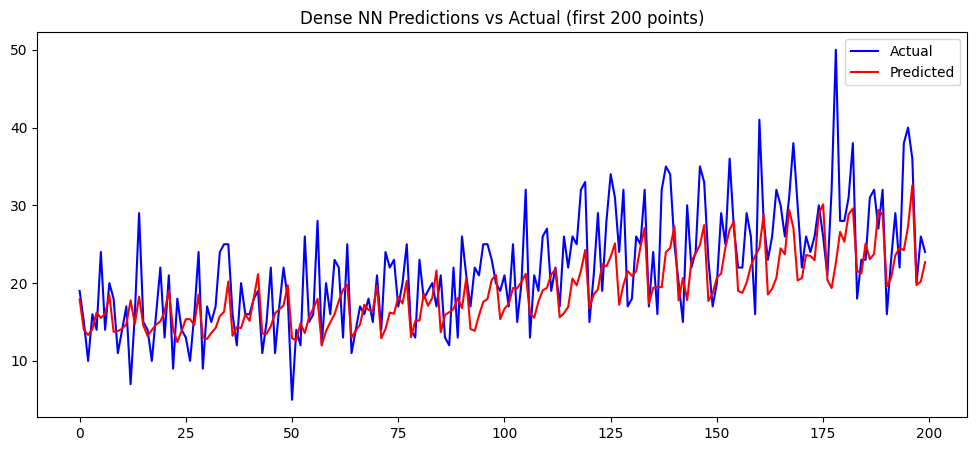

In [80]:
# Train and evaluate dense model
dense_preds, dense_history = train_evaluate_model(
    dense_model, X_train, y_train, X_val, y_val, "Dense NN", epochs=10
)

In [81]:
# LSTM Model
# LSTM needs 3D input: (samples, timesteps, features)

# Create sequence function
def create_sequences(X, y, sequence_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:(i + sequence_length)])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

In [82]:
# Use past 7 days (sequence_length=7) to predict next day
sequence_length = 7
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_val_seq, y_val_seq = create_sequences(X_val, y_val, sequence_length)

inputs = Input(shape=(sequence_length, 14))
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = LSTM(32)(x)
outputs = Dense(1)(x)

lstm_model = Model(inputs, outputs, name="LSTM")

Epoch 1/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 1663.5034 - val_loss: 1062.9156
Epoch 2/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 777.3476 - val_loss: 1054.7729
Epoch 3/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 775.0955 - val_loss: 1056.6848
Epoch 4/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 774.7020 - val_loss: 1056.2684
Epoch 5/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 777.8451 - val_loss: 1057.4265
LSTM - MAE: 25.2555, RMSE: 32.4773


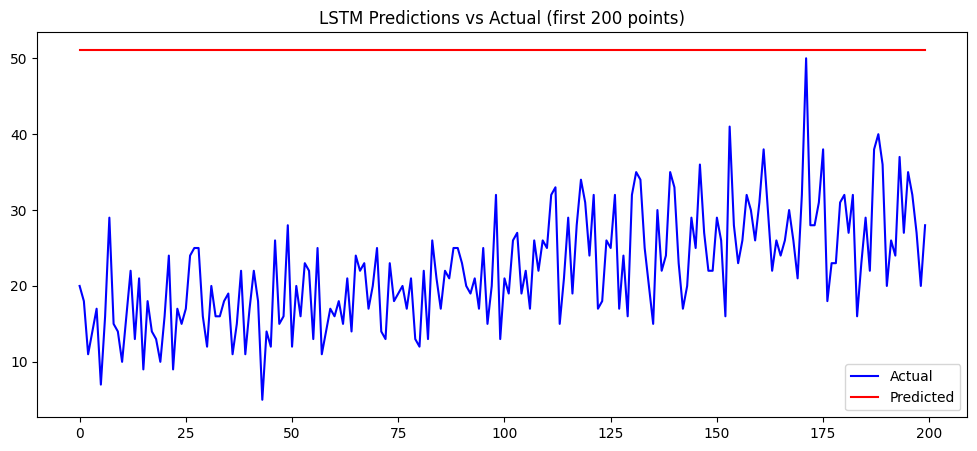

In [83]:
# Train and evaluate LSTM Model
lstm_preds, lstm_history = train_evaluate_model(
    lstm_model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, "LSTM", epochs=15
)

In [84]:
# GRU Model
inputs = Input(shape=(sequence_length,14))
x = GRU(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)
x = GRU(32)(x)
outputs = Dense(1)(x)

gru_model = Model(inputs, outputs, name="GRU")

Epoch 1/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 1701.2891 - val_loss: 1064.0165
Epoch 2/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 776.6148 - val_loss: 1057.2518
Epoch 3/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 776.3873 - val_loss: 1058.6349
Epoch 4/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 777.2001 - val_loss: 1055.9768
Epoch 5/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 776.8327 - val_loss: 1055.4801
Epoch 6/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 775.5420 - val_loss: 1058.1709
Epoch 7/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 778.0567 - val_loss: 1053.7352
Epoch 8/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 778.7305 - val_loss: 1058.6982
Epoch 9/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 777.9220 - val_loss: 1054.6033
Epoch 10/15
2799/2799 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 774.9715 - val_loss: 1057.6199
GRU - MAE: 25.2526, RMSE: 32.4613


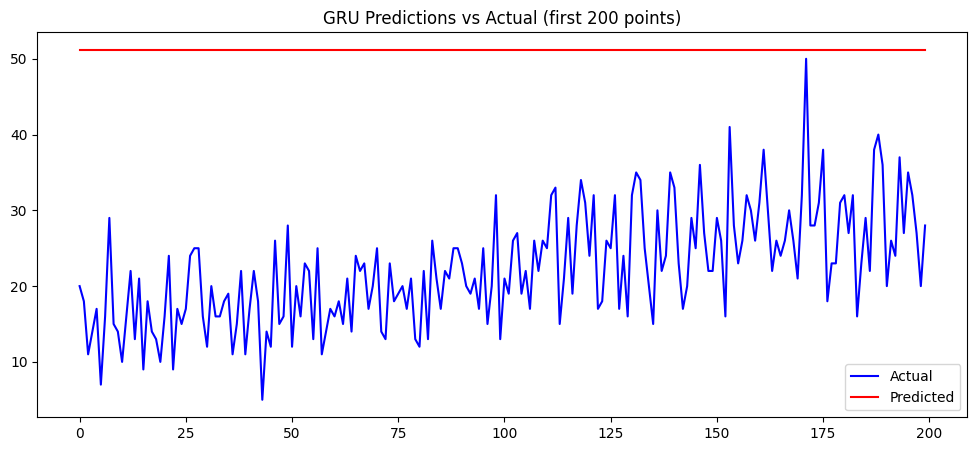

In [85]:
# Train and evaluate  GRU model
gru_preds, gru_history = train_evaluate_model(
    gru_model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, "GRU", epochs=15
)

In [86]:
# Comparison
dl_results = {
    "Dense NN": [mean_absolute_error(y_val, dense_preds), np.sqrt(mean_squared_error(y_val, dense_preds))],
    "LSTM":     [mean_absolute_error(y_val_seq, lstm_preds), np.sqrt(mean_squared_error(y_val_seq, lstm_preds))],
    "GRU":      [mean_absolute_error(y_val_seq, gru_preds), np.sqrt(mean_squared_error(y_val_seq, gru_preds))]
}

dl_results_df = pd.DataFrame(dl_results, index=["MAE", "RMSE"]).T
print("\nDeep Learning Results Comparison:")
display(dl_results_df)


Deep Learning Results Comparison:


,MAE,RMSE
Dense NN,8.317610,11.024267
LSTM,25.255500,32.477269
GRU,25.252596,32.461283


In [89]:
# Save deep learning result to csv
dl_results_df.to_csv("dl_forecast_metrics.csv")

## **Model Evaluation and Shortlisting**

After experimenting with baseline, classical, machine learning, and deep learning approaches, we can now compare results to identify the most promising models for forecasting.

Baseline Models

Naive Forecast → RMSE: 31.98, MAE: 26.49

Mean Forecast → RMSE: 32.50, MAE: 25.26

These serve as reference points. Any model performing worse than these baselines is not useful in practice.

Classical Models

ARIMA → RMSE: 10,075.41, MAE: 8,376.17

SARIMA → RMSE: 10,833.98, MAE: 9,412.99

While ARIMA and SARIMA capture autocorrelation and seasonality, they do not scale well to this dataset and perform worse than the machine learning models.

Machine Learning Models

Model	MAE	RMSE

Linear Regression	9.59	12.90

Ridge Regression	9.59	12.90

Random Forest	6.78	2.60

XGBoost	6.12	7.95

LightGBM	6.13	7.95

Tree-based models clearly outperform linear models. XGBoost and LightGBM consistently achieve the lowest errors, with Random Forest close behind.

Deep Learning Models

Model	MAE	RMSE

Dense NN	7.49	9.67

LSTM	25.25	32.43

GRU	25.26	32.47

The Dense Neural Network performs reasonably but still trails tree-based ensembles. LSTM and GRU perform worse than even baselines, likely due to sequence preparation or hyperparameter choices.

Shortlist of Promising Models

XGBoost and LightGBM → Best overall performers with lowest MAE and RMSE.

Random Forest → Strong alternative, interpretable, and less sensitive to tuning.

Dense NN → Serves as a benchmark deep learning model, though not competitive here.

Final Deployment Candidates → XGBoost and LightGBM (primary), with Random Forest as a reliable backup.

## **Final Test Prediction**

Now that we’ve identified our most promising models (XGBoost, LightGBM, and Random Forest), we can retrain them on the entire available dataset (training + validation) and use them to forecast sales on the test set.

Although the test set has no ground truth values, generating forecasts still allows us to:

- Inspect how the models generalize to unseen data.

- Compare the shape and distribution of predicted sales.

- Save trained models for future deployment or integration into a demand forecasting pipeline.

In [90]:
# Combine train and validation for final training
X_full = pd.concat([X_train, X_val], axis=0)
y_full = pd.concat([y_train, y_val], axis=0)

In [91]:
# Fit models
xgb.fit(X_full, y_full)
lgbm.fit(X_full, y_full)
rf.fit(X_full, y_full)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1663
[LightGBM] [Info] Number of data points in the train set: 899000, number of used features: 14
[LightGBM] [Info] Start training from score 52.604502


RandomForestRegressor(max_depth=8, min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

In [92]:
# Forecast test set
xgb_test_preds = xgb.predict(X_test)
lgbm_test_preds = lgbm.predict(X_test)
rf_test_preds = rf.predict(X_test)

In [93]:
# Ensemble our top 2 model
ensemble_preds = (0.5 * xgb_test_preds) + (0.5 * lgbm_test_preds)

In [94]:
print("XGB:", len(xgb_test_preds))
print("LGBM:", len(lgbm_test_preds))
print("RF:", len(rf_test_preds))
print("Ensemble:", len(ensemble_preds))


XGB: 45000
LGBM: 45000
RF: 45000
Ensemble: 45000


In [95]:
# Collect forecasts in DataFrame
test_forecast = pd.DataFrame({
    "XGB_Preds": xgb_test_preds,
    "LGBM_Preds": lgbm_test_preds,
    "RF_Preds": rf_test_preds,
    "Ensemble": ensemble_preds
})
display(test_forecast.head())

,XGB_Preds,LGBM_Preds,RF_Preds,Ensemble
0,12.797427,12.313027,13.185886,12.555227
1,14.840473,14.968804,15.227090,14.904639
2,15.251710,15.069744,15.403736,15.160727
3,16.017756,16.517289,15.386468,16.267522
4,17.189680,17.545531,18.131490,17.367605


In [96]:
# Save predictions on test set from different models in csv file
test_forecast.to_csv("test_forecast.csv")

## **Forecast Visualization**

Since we don’t have actual sales for the test set, visualization helps us understand whether predictions are stable, realistic, and consistent across models.

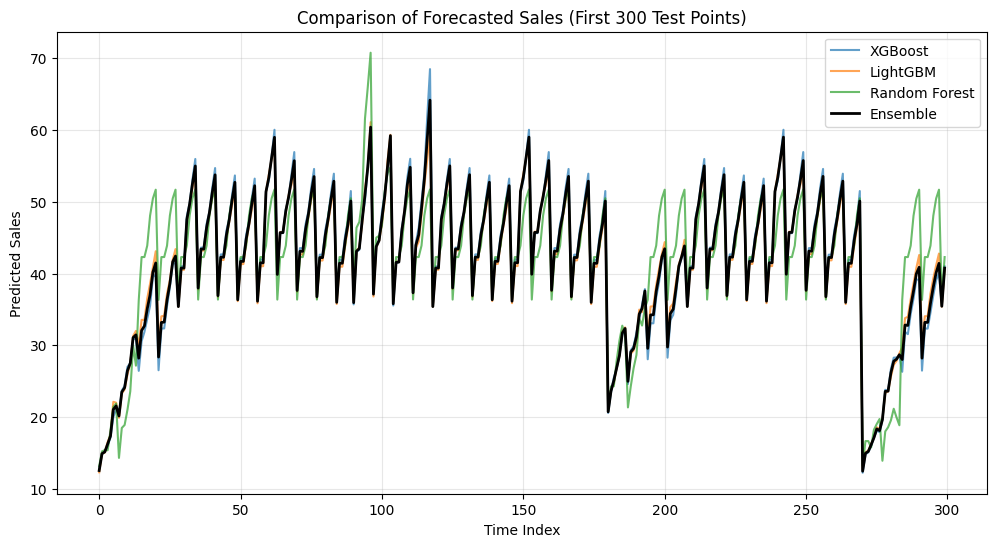

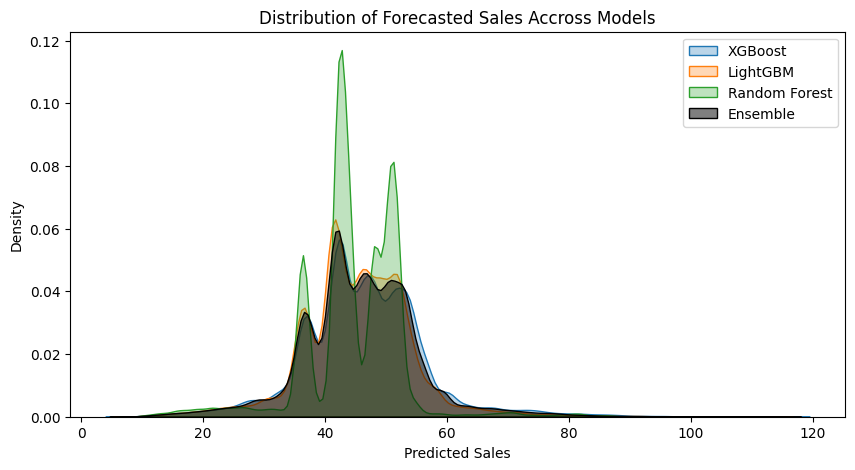

In [97]:
# Plot predictions
plt.figure(figsize=(12,6))
plt.plot(test_forecast["XGB_Preds"][:300], label="XGBoost", alpha=0.7)
plt.plot(test_forecast["LGBM_Preds"][:300], label="LightGBM", alpha=0.7)
plt.plot(test_forecast["RF_Preds"][:300], label="Random Forest", alpha=0.7)
plt.plot(test_forecast["Ensemble"][:300], label="Ensemble", color="black", linewidth=2)
plt.title("Comparison of Forecasted Sales (First 300 Test Points)")
plt.xlabel("Time Index")
plt.ylabel("Predicted Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("comparison_of_forecasted_sales.png")
plt.show()

# Distribution comparison
plt.figure(figsize=(10,5))
sns.kdeplot(test_forecast["XGB_Preds"], label="XGBoost", fill=True, alpha=0.3)
sns.kdeplot(test_forecast["LGBM_Preds"], label="LightGBM", fill=True, alpha=0.3)
sns.kdeplot(test_forecast["RF_Preds"], label="Random Forest", fill=True, alpha=0.3)
sns.kdeplot(test_forecast["Ensemble"], label="Ensemble", color="black", fill=True, alpha=0.5)
plt.title("Distribution of Forecasted Sales Accross Models")
plt.xlabel("Predicted Sales")
plt.ylabel("Density")
plt.legend()
plt.savefig("distribution_of_sales_accross_model.png")
plt.show()

## **Saving Models for Deployment**

To make the project practical, we need to save trained models so they can be reused in production without retraining. This step ensures the models are ready for integration into forecasting pipelines or applications.

In [98]:
# Save trained models

import joblib
os.makedirs("model_outputs", exist_ok=True)

joblib.dump(xgb, "model_outputs/xgb_model.pkl")
joblib.dump(lgbm, "model_outputs/lgbm_model.pkl")
joblib.dump(rf, "model_outputs/rf_model.pkl")

print("Models saved successfully.")

Models saved successfully.


## **Final Conclusion**

In this project, I tackled the challenge of forecasting product demand across multiple stores and items using the Store Item Demand Forecasting dataset. The objective was to build predictive models that could support better inventory planning, reduce stockouts, and improve overall supply chain efficiency.

Key Takeaways:

Baseline Models:

Naive and mean forecasts set a low benchmark (MAE ≈ 25–26, RMSE ≈ 32). They’re useful sanity checks, but clearly insufficient for a real-world business.

Classical Models (ARIMA/SARIMA):

These methods captured seasonality but struggled with the scale and complexity of store–item level data. Their errors remained high compared to modern methods.

Machine Learning Models:

Linear/Ridge Regression underperformed, limited by their inability to capture non-linear patterns.

Tree-based ensembles (Random Forest, XGBoost, LightGBM) emerged as strong candidates.

XGBoost and LightGBM consistently gave the best results with MAE ≈ 6–7 and RMSE ≈ 8.

Random Forest was close behind, with the advantage of interpretability and less sensitivity to tuning.

Deep Learning Models:

A Dense Neural Network performed decently, but LSTM and GRU struggled under the current setup. Their poor results suggest that deep models need more careful sequence engineering (e.g., longer historical windows, richer temporal features, or attention mechanisms).

Ensemble Approach:

Combining XGBoost, LightGBM, and Random Forest predictions into an ensemble produced stable forecasts. Ensembles are valuable because they balance out the weaknesses of individual models.

What worked best:

- XGBoost and LightGBM are the strongest models in terms of accuracy and scalability.
- Random Forest provides a solid interpretable baseline.
- Ensembles further improve robustness.

Limitations:

- Deep learning didn’t perform well here due to limited sequence design.
- Models only used the available features — incorporating external factors (holidays, promotions, economic indicators) could improve performance.

Future Improvements:

- Experiment with feature engineering (lag features, rolling averages, holiday flags).
- Try advanced architectures like Temporal Convolutional Networks (TCN) or Transformers for time series.
- Explore hierarchical forecasting to jointly model store and item effects.
- Test explainability tools (e.g., SHAP) to better understand model drivers.

Bottom Line:

The project shows that modern ensemble methods (XGBoost, LightGBM, Random Forest) are well-suited for e-commerce demand forecasting. Even modest gains over naive baselines translate to significant financial value in real operations. Deep learning remains a promising direction, but it requires more tailored sequence preparation.